<a href="https://colab.research.google.com/github/nmhaddad/python-machine-learning-youtube/blob/master/cs6140_project_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pattern Recognition in Daily Top Trending YouTube Videos**

***

Word2Vec Word Embedding Sub-Experiment
---


# Setup

***

**Imports**

In [0]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import numpy as np
import re
import seaborn as sns
from gensim.test.utils import common_texts
from gensim.models import Phrases
import nltk
from nltk.corpus import stopwords
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

%load_ext Cython
%matplotlib inline

**Load Data From Google Drive**

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Read-in CSV & JSON**

In [0]:
videos = pd.read_csv("/content/drive/My Drive/cs6140 project/data/USvideos.csv")
videos_categories = pd.read_json("/content/drive/My Drive/cs6140 project/data/US_category_id.json")

In [0]:
videos.head(1)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...


# Data Pre-Processing 

***

This block of code links the csv to json categories

In [0]:
# source: https://www.kaggle.com/skalskip/youtube-data-exploration-and-plotly-visualization

categories = {category['id']: category['snippet']['title'] for category in videos_categories['items']}
videos.insert(4, 'category', videos['category_id'].astype(str).map(categories))

Remove NaN Errors

In [0]:
print(videos.shape[0])

40949


In [0]:
videos = videos.dropna()

In [0]:
print(videos.shape[0])

40379


**Creating New Attributes**

In [0]:
videos["likes_per_view"] = videos["likes"]/videos["views"]
videos["dislikes_per_view"] = videos["dislikes"]/videos["views"]
videos["comments_per_view"] = videos["comment_count"]/videos["views"]

videos["total_likes_dislikes"] = videos["likes"] + videos["dislikes"]
videos["total_likes_dislikes_per_view"] = videos["total_likes_dislikes"]/videos["views"]

videos["likes_percentage"] = videos["likes"]/videos["total_likes_dislikes"]
videos["dislikes_percentage"] =videos["dislikes"]/videos["total_likes_dislikes"]

In [0]:
# source https://www.kaggle.com/skalskip/youtube-data-exploration-and-plotly-visualization

videos['trending_date'] = pd.to_datetime(videos['trending_date'], format='%y.%d.%m').dt.date
reformatted_time = pd.to_datetime(videos['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
videos['publish_date'] = reformatted_time.dt.date
videos['publish_time'] = reformatted_time.dt.time
videos['publish_hour'] = reformatted_time.dt.hour

**Text Pre-Processing**

In [0]:
# get the number of characters in a given title
videos["title_characters"] = videos["title"].apply(lambda x : len(x))
# get the number of words in a given title
videos["title_words"] = videos["title"].apply(lambda x : len(x.split()))

In [0]:
# get the number of characters in a given description
videos["description_characters"] = videos["description"].apply(lambda x : len(str(x)))
# get the number of words in a given description
videos["description_words"] = videos["description"].apply(lambda x : len(str(x).split()))

**Normalize**

In [0]:
videos = videos.dropna()

In [0]:
videos.sample(1)

,video_id,trending_date,title,channel_title,category,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,likes_per_view,dislikes_per_view,comments_per_view,total_likes_dislikes,total_likes_dislikes_per_view,likes_percentage,dislikes_percentage,publish_date,publish_hour,title_characters,title_words,description_characters,description_words
33052,hdoLeKGoSjw,2018-05-06,10 Ridiculous Cooking Products!,Matthias,Comedy,23,16:50:00,"cooking|""snack ideas""|""testing products""|""food...",1232298,32639,1126,11455,https://i.ytimg.com/vi/hdoLeKGoSjw/default.jpg,False,False,False,Found a product you'd like us to review? Share...,0.026486,0.000914,0.009296,33765,0.0274,0.966652,0.033348,2018-04-28,16,31,4,1226,144


In [0]:
min_max_scaler = preprocessing.MinMaxScaler()

col = ['views','likes','dislikes','comment_count','likes_per_view',
       'comments_per_view','total_likes_dislikes_per_view','likes_percentage',
       'dislikes_percentage','publish_hour','title_characters','title_words',
       'description_characters','description_words','total_likes_dislikes']

for column in col:
  x = videos[col].values.astype('float32')
  normed_videos = min_max_scaler.fit_transform(x)
  videos[col] = pd.DataFrame(normed_videos)

**Remove Duplicates**

The outcome of this experiment will be heavily impacted by duplicate videos

In [0]:
print(videos.shape[0])

40209


In [0]:
videos.drop_duplicates(subset="title", keep="last", inplace=True)

In [0]:
print(videos.shape[0])

6328


**Create functions for tokenizing text**

In [0]:
nltk.download("stopwords")
STOPWORDS = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
"""
function: tokenize_titles
param(s): text, a string
returns: a list of tokenized strings
"""
def tokenize_titles(text):
  ret_list = []
  # split text into list of words
  data = str(text).split()
  for token in data:
    # remove text that is not made of letters
    word = ""
    for char in token:
      char = char.lower()
      if ascii(char) >= ascii("a") and ascii(char) <= ascii("z"):
        word += char
    # remove empty strings and stopwords
    if word is not "" and word not in STOPWORDS:
      ret_list.append(word)
  return ret_list


"""
function: tokenize_tags
param(s): text, a string
returns: a list of tokenized strings
"""
def tokenize_tags(text):
  ret_list = []
  # split text into list of words
  data = re.split("\"| |\|", str(text))
  for token in data:
    # remove text that is not made of letters
    word = ""
    for char in token:
      char = char.lower()
      if ascii(char) >= ascii("a") and ascii(char) <= ascii("z"):
        word += char
    if word is not "" and word not in STOPWORDS:
      ret_list.append(word)

  return ret_list

**Create ```data``` variable for neural network learning**

In [0]:
titles = videos["title"].apply(tokenize_titles)
tags = videos["tags"].apply(tokenize_tags)
channels = videos["channel_title"].apply(tokenize_titles)
descriptions = videos["description"].apply(tokenize_titles)
categories_1 = videos["category"].apply(tokenize_titles)

data = titles + tags + channels + descriptions + categories_1

# Learning Word Embeddings with Word2Vec

***

For this sub-experiment, we will test the gensim Word2Vec model on our daily top trending YouTube dataset.

***

**Word2Vec (cbow)**

The models used for this sub-experiment are word embedding neural networks that learn the values of words so that the words are quantifiable

The first function, ```model``` is a function that is trained using a continuous bag of words

In [0]:
# train continuous bag of words model
cbow_model = Word2Vec(data, min_count=1, size=200, window=5, workers=4)

***

**Word2Vec (sg)**

The second function, ```sg_model```, is a function that uses skip grams

In [0]:
# train skip gram model
sg_model = Word2Vec(data, min_count = 1, size = 200, window = 5, sg = 1, workers=4) 

***
**Test examples**

In [0]:
# source: geeksforgeeks

print("Cosine similarity between 'black' " + "and 'black' - CBOW:     {0:.4f}".format(cbow_model.wv.similarity("black", "black")))
print("Cosine similarity between 'black' " + "and 'black' - SG:       {0:.4f}".format(sg_model.wv.similarity("black", "black")))

print("Cosine similarity between 'panther' " + "and 'panther' - CBOW: {0:.4f}".format(cbow_model.wv.similarity("panther", "panther")))
print("Cosine similarity between 'panther' " + "and 'panther' - SG:   {0:.4f}".format(sg_model.wv.similarity("panther", "panther")))

print("Cosine similarity between 'black' " + "and 'panther' - CBOW:   {0:.4f}".format(cbow_model.wv.similarity("black", "panther")))
print("Cosine similarity between 'black' " + "and 'panther' - SG:     {0:.4f}".format(sg_model.wv.similarity("black", "panther")))

print("Cosine similarity between 'panther' " + "and 'black' - CBOW:   {0:.4f}".format(cbow_model.wv.similarity("black", "panther")))
print("Cosine similarity between 'panther' " + "and 'black' - SG:     {0:.4f}".format(sg_model.wv.similarity("black", "panther")))

Cosine similarity between 'black' and 'black' - CBOW:     1.0000
Cosine similarity between 'black' and 'black' - SG:       1.0000
Cosine similarity between 'panther' and 'panther' - CBOW: 1.0000
Cosine similarity between 'panther' and 'panther' - SG:   1.0000
Cosine similarity between 'black' and 'panther' - CBOW:   0.9712
Cosine similarity between 'black' and 'panther' - SG:     0.8421
Cosine similarity between 'panther' and 'black' - CBOW:   0.9712
Cosine similarity between 'panther' and 'black' - SG:     0.8421


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


**Create functions for comparing two texts**

In [0]:
"""
function: get_similarities
param(s): text_one, a list of strings; text_two, a list of strings
returns: the average similarity of text_one to text_two
does: gets the similarity (avg) between two lists of strings for cbow and sg 
      word2vec models
"""
def get_similarities(text_one, text_two):
  cbow_total=0
  sg_total=0
  count=0
  for word_one in text_one:
    cbow_max = np.NINF
    sg_max = np.NINF
    for word_two in text_two:
      # get continuous bag of words similarity
      cbow_max = max(cbow_max, cbow_model.wv.similarity(word_one, word_two))
      # get skip gram similarity
      sg_max = max(sg_max, sg_model.wv.similarity(word_one, word_two))
    if cbow_max > np.NINF or sg_max > np.NINF:
      cbow_total += cbow_max
      sg_total += sg_max
      count += 1
  if count is 0:
    return 0, 0
  return cbow_total/count, sg_total/count

In [0]:
"""
function: word2vecNLP
param(s): list_one, a list of strings; list_two, a list of strings
returns: the average similarity of list_one to list_two
"""
def word2vecNLP(list_one, list_two):
  cbow_list = []
  sg_list = []

  for i in range(len(list_one)):
    cbow, sg = get_similarities(list_one[i], list_two[i])
    cbow_list.append(cbow)
    sg_list.append(sg)

  return cbow_list, sg_list

Prepare data

In [0]:
# convert dataframes to lists
titles_list = titles.tolist()
tags_list = tags.tolist()
descriptions_list = descriptions.tolist()
channels_list = channels.tolist()
categories_list = categories_1.tolist()

***

**Test with compare tiles and titles**

In [0]:
cbow, sg = word2vecNLP(titles_list, titles_list)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
print(len(videos))
print(len(cbow))
print(len(sg))

6328
6328
6328


In [0]:
# add lists to dataframe
videos["cbow_titles_titles"] = cbow
videos["sg_titles_titles"] = sg

In [0]:
# replace 0 values with mean
# we use the mean because the mean also is equal to the word embeddings of the most common words for this document
videos["cbow_titles_titles"] = videos["cbow_titles_titles"].replace(0, videos["cbow_titles_titles"].mean())
videos["sg_titles_titles"]= videos["sg_titles_titles"].replace(0, videos["sg_titles_titles"].mean())

In [0]:
print("Cosine similarity between titles and titles - CBOW:     {0:.4f}".format(videos["cbow_titles_titles"].mean()))
print("Cosine similarity between titles and titles - SG:       {0:.4f}".format(videos["sg_titles_titles"].mean()))

Cosine similarity between titles and titles - CBOW:     1.0000
Cosine similarity between titles and titles - SG:       1.0000


# Compare Titles and Tags

***

**Using Word2Vec neural networks, get the similarities of titles and tags**

In [0]:
cbow, sg = word2vecNLP(titles_list, tags_list)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
# add lists to dataframe
videos["cbow_titles_tags"] = cbow
videos["sg_titles_tags"] = sg

In [0]:
# replace 0 values with mean
videos["cbow_titles_tags"] = videos["cbow_titles_tags"].replace(0.0, videos["cbow_titles_tags"].mean())
videos["sg_titles_tags"] = videos["sg_titles_tags"].replace(0.0, videos["sg_titles_tags"].mean())

**Average Similarities**

In [0]:
print("Cosine similarity between titles and tags - CBOW:     {0:.4f}".format(videos["cbow_titles_tags"].mean()))
print("Cosine similarity between titles and tags - SG:       {0:.4f}".format(videos["sg_titles_tags"].mean()))

Cosine similarity between titles and tags - CBOW:     0.9503
Cosine similarity between titles and tags - SG:       0.8952


**Visualization**

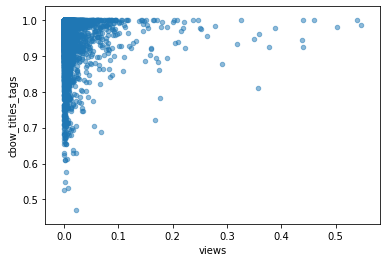

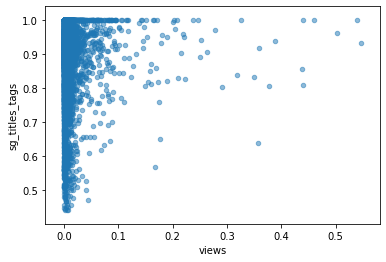

In [0]:
videos.plot(kind="scatter", x="views", y="cbow_titles_tags", alpha=0.5)
videos.plot(kind="scatter", x="views", y="sg_titles_tags", alpha=0.5)

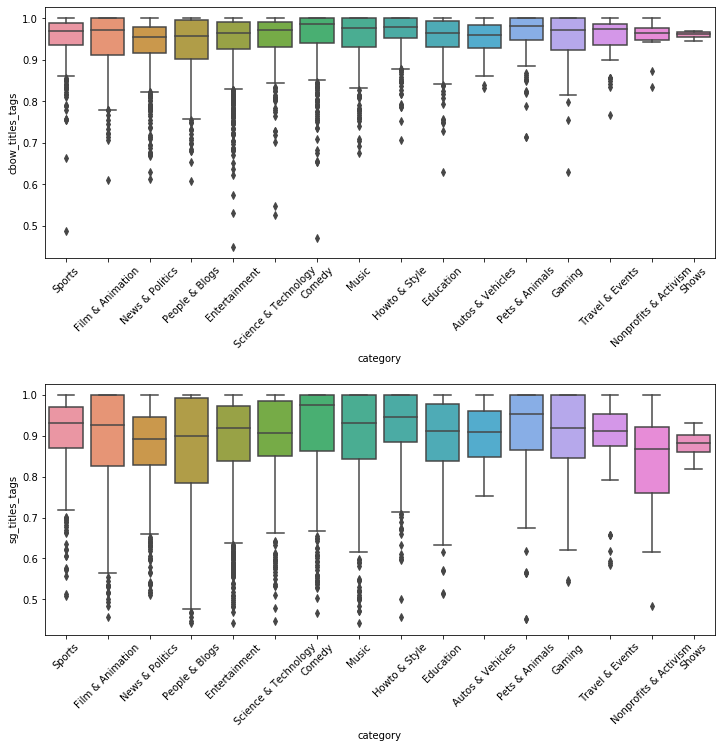

In [0]:
# source https://www.kaggle.com/kabure/extensive-usa-youtube-eda

plt.figure(figsize = (12,18))

plt.subplot(311)
cat_graph_1 = sns.boxplot(x='category',y='cbow_titles_tags',  data=videos)
cat_graph_1.set_xticklabels(cat_graph_1.get_xticklabels(),rotation=45)

plt.subplot(312)
cat_graph_2 = sns.boxplot(x='category',y='sg_titles_tags',  data=videos)
cat_graph_2.set_xticklabels(cat_graph_2.get_xticklabels(),rotation=45)

plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.9)

plt.show()

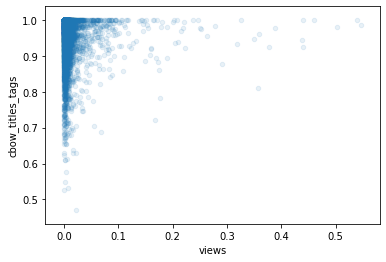

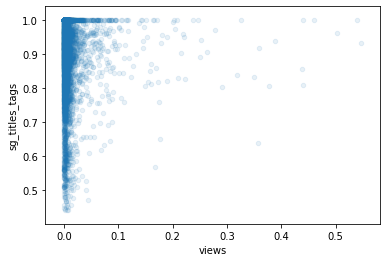

In [0]:
videos.plot(kind="scatter", x="views", y="cbow_titles_tags", alpha=0.1)
videos.plot(kind="scatter", x="views", y="sg_titles_tags", alpha=0.1)

# Compare Titles and Descriptions

***

**Using Word2Vec neural networks, get the similarities of titles and descriptions**

In [0]:
cbow, sg = word2vecNLP(titles_list, descriptions_list)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
# add lists to dataframe
videos["cbow_titles_descriptions"] = cbow
videos["sg_titles_descriptions"] = sg

In [0]:
# replace 0 values with mean
videos["cbow_titles_descriptions"] = videos["cbow_titles_descriptions"].replace(0, videos["cbow_titles_descriptions"].mean())
videos["sg_titles_descriptions"] = videos["sg_titles_descriptions"].replace(0, videos["sg_titles_descriptions"].mean())

**Average Similarities**

In [0]:
print("Cosine similarity between titles and descriptions - CBOW:     {0:.4f}".format(videos["cbow_titles_descriptions"].mean()))
print("Cosine similarity between titles and descriptions - SG:       {0:.4f}".format(videos["sg_titles_descriptions"].mean()))

Cosine similarity between titles and descriptions - CBOW:     0.9534
Cosine similarity between titles and descriptions - SG:       0.8998


**Visualization**

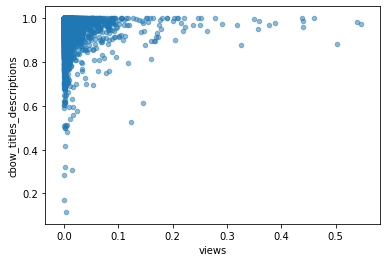

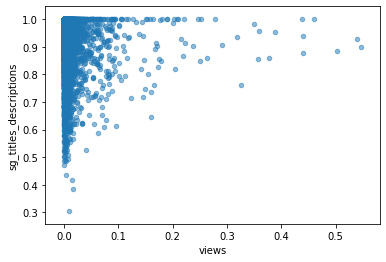

In [0]:
videos.plot(kind="scatter", x="views", y="cbow_titles_descriptions", alpha=0.5)
videos.plot(kind="scatter", x="views", y="sg_titles_descriptions", alpha=0.5)

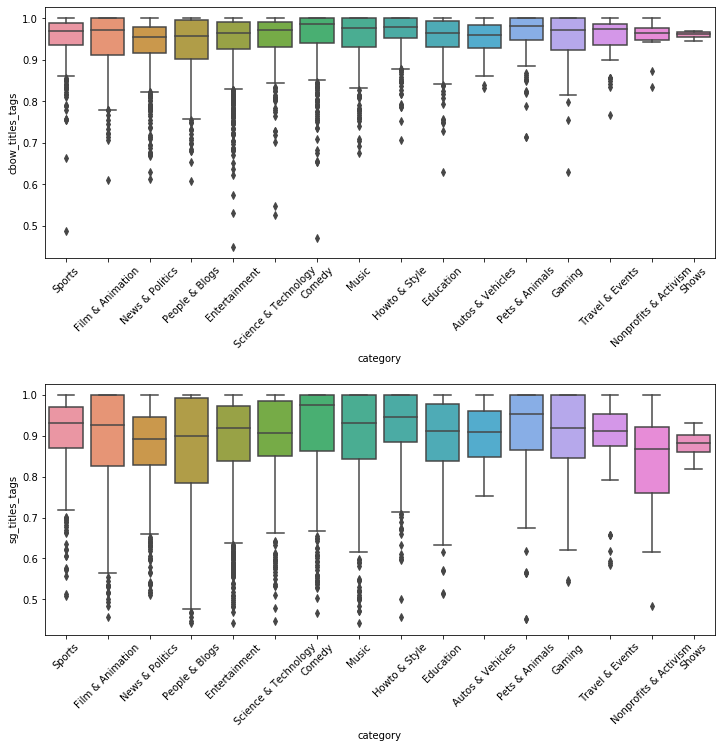

In [0]:
# source https://www.kaggle.com/kabure/extensive-usa-youtube-eda

plt.figure(figsize = (12,18))

plt.subplot(311)
cat_graph_1 = sns.boxplot(x='category',y='cbow_titles_tags',  data=videos)
cat_graph_1.set_xticklabels(cat_graph_1.get_xticklabels(),rotation=45)

plt.subplot(312)
cat_graph_2 = sns.boxplot(x='category',y='sg_titles_tags',  data=videos)
cat_graph_2.set_xticklabels(cat_graph_2.get_xticklabels(),rotation=45)

plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.9)

plt.show()

# Compare Titles and Channels

***

**Using Word2Vec neural networks, get the similarities of titles and channels**

In [0]:
cbow, sg = word2vecNLP(titles_list, channels_list)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
# add lists to dataframe
videos["cbow_titles_channels"] = cbow
videos["sg_titles_channels"] = sg

In [0]:
# replace 0 values with mean
videos["cbow_titles_channels"] = videos["cbow_titles_channels"].replace(0, videos["cbow_titles_channels"].mean())
videos["sg_titles_channels"] = videos["sg_titles_channels"].replace(0, videos["sg_titles_channels"].mean())

**Average Similarities**

In [0]:
print("Cosine similarity between titles and channels - CBOW:     {0:.4f}".format(videos["cbow_titles_channels"].mean()))
print("Cosine similarity between titles and channels - SG:       {0:.4f}".format(videos["sg_titles_channels"].mean()))

Cosine similarity between titles and channels - CBOW:     0.7714
Cosine similarity between titles and channels - SG:       0.6692


**Visualization**

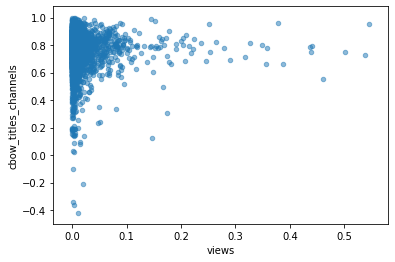

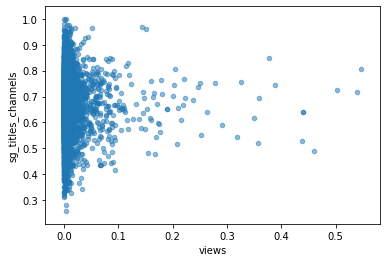

In [0]:
videos.plot(kind="scatter", x="views", y="cbow_titles_channels", alpha=0.5)
videos.plot(kind="scatter", x="views", y="sg_titles_channels", alpha=0.5)

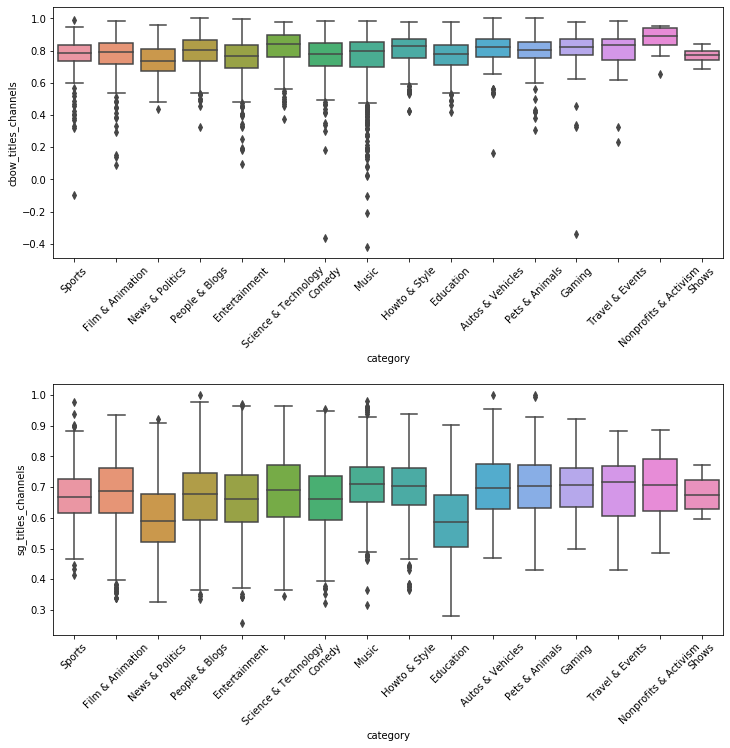

In [0]:
# source https://www.kaggle.com/kabure/extensive-usa-youtube-eda

plt.figure(figsize = (12,18))

plt.subplot(311)
cat_graph_1 = sns.boxplot(x='category',y='cbow_titles_channels',  data=videos)
cat_graph_1.set_xticklabels(cat_graph_1.get_xticklabels(),rotation=45)

plt.subplot(312)
cat_graph_2 = sns.boxplot(x='category',y='sg_titles_channels',  data=videos)
cat_graph_2.set_xticklabels(cat_graph_2.get_xticklabels(),rotation=45)

plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.9)

plt.show()

# Compares Titles and Categories

***

**Using Word2Vec neural networks, get the similarities of titles and categories**

In [0]:
cbow, sg = word2vecNLP(titles_list, categories_list)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
# add lists to dataframe
videos["cbow_titles_categories"] = cbow
videos["sg_titles_categories"] = sg

In [0]:
# replace 0 values with mean
videos["cbow_titles_categories"] = videos["cbow_titles_categories"].replace(0, videos["cbow_titles_categories"].mean())
videos["sg_titles_categories"] = videos["sg_titles_categories"].replace(0, videos["sg_titles_categories"].mean())

**Average Similarities**

In [0]:
print("Cosine similarity between titles and categories - CBOW:     {0:.4f}".format(videos["cbow_titles_categories"].mean()))
print("Cosine similarity between titles and categories - SG:       {0:.4f}".format(videos["sg_titles_categories"].mean()))

Cosine similarity between titles and categories - CBOW:     0.6116
Cosine similarity between titles and categories - SG:       0.3721


**Visualization**

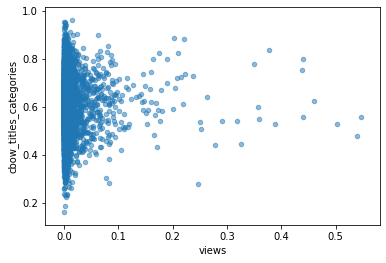

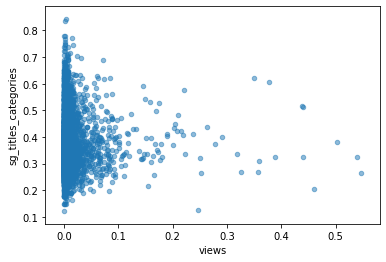

In [0]:
videos.plot(kind="scatter", x="views", y="cbow_titles_categories", alpha=0.5)
videos.plot(kind="scatter", x="views", y="sg_titles_categories", alpha=0.5)

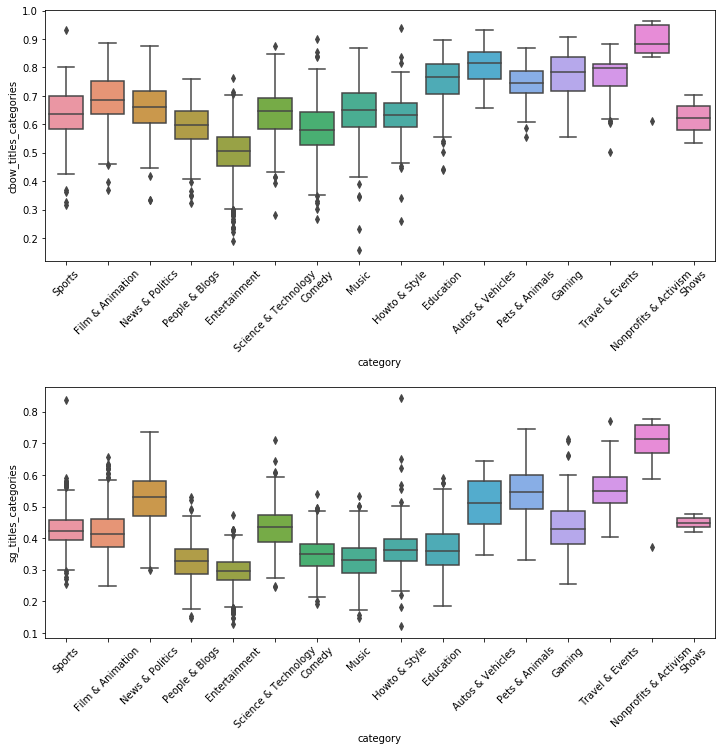

In [0]:
# source https://www.kaggle.com/kabure/extensive-usa-youtube-eda

plt.figure(figsize = (12,18))

plt.subplot(311)
cat_graph_1 = sns.boxplot(x='category',y='cbow_titles_categories',  data=videos)
cat_graph_1.set_xticklabels(cat_graph_1.get_xticklabels(),rotation=45)

plt.subplot(312)
cat_graph_2 = sns.boxplot(x='category',y='sg_titles_categories',  data=videos)
cat_graph_2.set_xticklabels(cat_graph_2.get_xticklabels(),rotation=45)

plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.9)

plt.show()

# Compare Tags and Categories

***

**Using Word2Vec neural networks, get the similarities of tags and categories**

In [0]:
cbow, sg = word2vecNLP(tags_list, categories_list)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
# add lists to dataframe
videos["cbow_tags_categories"] = cbow
videos["sg_tags_categories"] = sg

In [0]:
# replace 0 values with mean
videos["cbow_tags_categories"] = videos["cbow_tags_categories"].replace(0, videos["cbow_tags_categories"].mean())
videos["sg_tags_categories"] = videos["sg_tags_categories"].replace(0, videos["sg_tags_categories"].mean())

**Average Similarities**

In [0]:
print("Cosine similarity between tags and categories - CBOW:     {0:.4f}".format(videos["cbow_tags_categories"].mean()))
print("Cosine similarity between tags and categories - SG:       {0:.4f}".format(videos["sg_tags_categories"].mean()))

Cosine similarity between tags and categories - CBOW:     0.6310
Cosine similarity between tags and categories - SG:       0.3920


**Visualization**

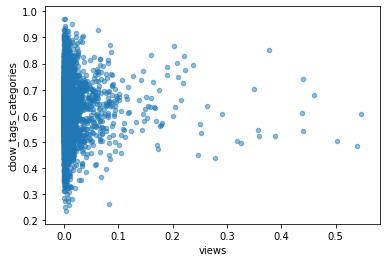

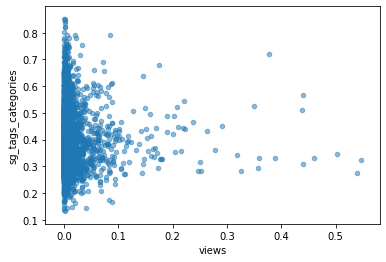

In [0]:
videos.plot(kind="scatter", x="views", y="cbow_tags_categories", alpha=0.5)
videos.plot(kind="scatter", x="views", y="sg_tags_categories", alpha=0.5)

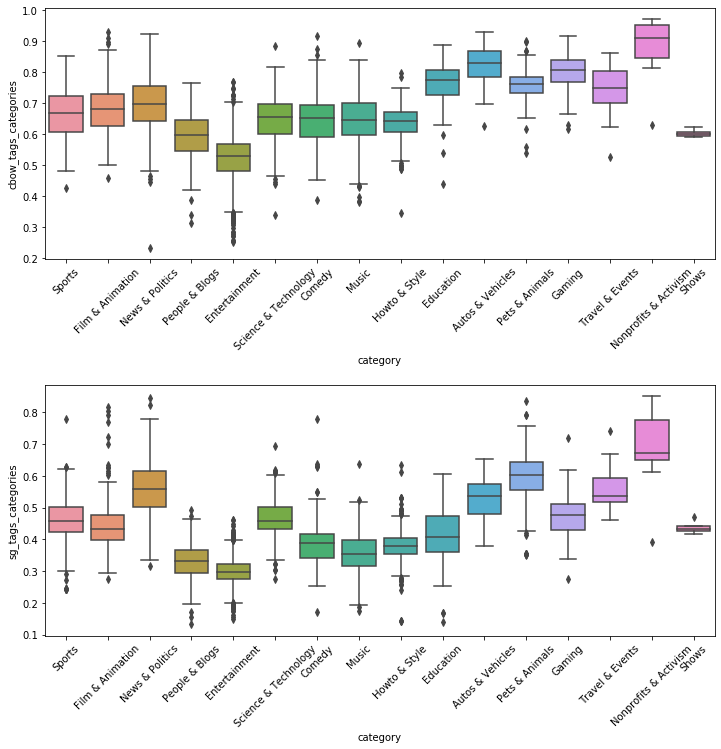

In [0]:
# source https://www.kaggle.com/kabure/extensive-usa-youtube-eda

plt.figure(figsize = (12,18))

plt.subplot(311)
cat_graph_1 = sns.boxplot(x='category',y='cbow_tags_categories',  data=videos)
cat_graph_1.set_xticklabels(cat_graph_1.get_xticklabels(),rotation=45)

plt.subplot(312)
cat_graph_2 = sns.boxplot(x='category',y='sg_tags_categories',  data=videos)
cat_graph_2.set_xticklabels(cat_graph_2.get_xticklabels(),rotation=45)

plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.9)

plt.show()

# Regression Using Word2Vec Values

***

NOTE: incomplete, as we decided to predict using a different notebook. See cs6140_project_Classification.ipynb

In [0]:
videos.head(1)

,video_id,trending_date,title,channel_title,category,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,likes_per_view,dislikes_per_view,comments_per_view,total_likes_dislikes,total_likes_dislikes_per_view,likes_percentage,dislikes_percentage,publish_date,publish_hour,title_characters,title_words,description_characters,description_words,cbow_titles_titles,sg_titles_titles,cbow_titles_tags,sg_titles_tags,cbow_titles_descriptions,sg_titles_descriptions,cbow_titles_channels,sg_titles_channels,cbow_titles_categories,sg_titles_categories,cbow_tags_categories,sg_tags_categories
10,9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,Sports,17,02:05:26,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",0.000359,0.000117,0.000015,0.000144,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,False,False,False,New England Patriots returner Dion Lewis blast...,0.029743,0.000307,0.019165,0.000117,0.029812,0.963235,0.036765,2017-11-13,0.086957,0.85567,0.681818,0.25166,0.159548,1.0,1.0,0.944866,0.950036,0.9291,0.9075,0.754475,0.643219,0.634868,0.456489,0.733073,0.511195


In [0]:
# create training and testing sets
train_dataset = videos.sample(frac=0.8,random_state=12345)
test_dataset = videos.drop(train_dataset.index)

In [0]:
train_dataset['comments_disabled'] = (train_dataset['comments_disabled'] == 'True').astype(int)
train_dataset['ratings_disabled'] = (train_dataset['ratings_disabled'] == 'True').astype(int)
train_dataset['video_error_or_removed'] = (train_dataset['video_error_or_removed'] == 'True').astype(int)

test_dataset['comments_disabled'] = (test_dataset['comments_disabled'] == 'True').astype(int)
test_dataset['ratings_disabled'] = (test_dataset['ratings_disabled'] == 'True').astype(int)
test_dataset['video_error_or_removed'] = (test_dataset['video_error_or_removed'] == 'True').astype(int)

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [0]:
train_dataset = train_dataset.drop(columns=['video_id','trending_date',
                                            'channel_title','category',
                                            'category_id','publish_time',
                                            'tags','thumbnail_link',
                                            'description','title',
                                            'publish_date'])

test_dataset = test_dataset.drop(columns=['video_id','trending_date',
                                            'channel_title','category',
                                            'category_id','publish_time',
                                            'tags','thumbnail_link',
                                            'description','title',
                                            'publish_date'])

In [0]:
train_dataset_ii = train_dataset
test_dataset_ii = test_dataset

In [0]:
train_dataset.head()

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,likes_per_view,dislikes_per_view,comments_per_view,total_likes_dislikes,total_likes_dislikes_per_view,likes_percentage,dislikes_percentage,publish_hour,title_characters,title_words,description_characters,description_words,cbow_titles_titles,sg_titles_titles,cbow_titles_tags,sg_titles_tags,cbow_titles_descriptions,sg_titles_descriptions,cbow_titles_channels,sg_titles_channels,cbow_titles_categories,sg_titles_categories,cbow_tags_categories,sg_tags_categories
20168,0.004730,0.005062,0.000252,0.001660,0,0,0,0.098533,0.000808,0.016867,0.004953,0.097166,0.985640,0.014360,0.913043,0.546392,0.500000,0.084733,0.050251,1.0,1.0,0.865871,0.845940,0.834491,0.815003,0.689720,0.616508,0.520099,0.555114,0.698096,0.637555
25278,0.009125,0.021443,0.000458,0.003965,0,0,0,0.216395,0.000551,0.020884,0.020810,0.211985,0.993792,0.006208,0.695652,0.505155,0.409091,0.167513,0.113065,1.0,1.0,0.895750,0.769369,0.989243,0.950953,0.587747,0.501242,0.577024,0.312631,0.592018,0.357313
4581,0.005432,0.023185,0.000268,0.013486,0,0,0,0.393004,0.001058,0.119300,0.022437,0.384135,0.996623,0.003377,0.826087,0.432990,0.363636,0.187036,0.079146,1.0,1.0,0.767786,0.441394,0.844680,0.550062,0.811905,0.553824,0.730105,0.378650,0.626668,0.209376
40756,NaN,NaN,NaN,NaN,0,0,0,NaN,0.001365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.956141,0.880861,0.987657,0.939118,0.835360,0.757009,0.789685,0.430535,0.693029,0.418796
23951,0.003771,0.008717,0.000423,0.000409,0,0,0,0.212779,0.000424,0.005215,0.008526,0.210088,0.985996,0.014004,0.652174,0.474227,0.363636,0.238188,0.155779,1.0,1.0,0.968590,0.975098,0.939856,0.922551,0.835453,0.791457,0.517007,0.326108,0.629721,0.342187


In [0]:
# clean data
train_dataset = train_dataset.dropna()
test_dataset = test_dataset.dropna()

In [0]:
# get labels
train_labels = train_dataset.pop('views')
test_labels = test_dataset.pop('views')

In [0]:
# normalize datasets
min_max_scaler = preprocessing.MinMaxScaler()

x = train_dataset.values.astype('float32')
normed_videos = min_max_scaler.fit_transform(x)
train_dataset = pd.DataFrame(normed_videos)

x = test_dataset.values.astype('float32')
normed_videos = min_max_scaler.fit_transform(x)
test_dataset = pd.DataFrame(normed_videos)

In [0]:
# get lengths of train and test datasets
print(train_dataset.shape[0])
print(test_dataset.shape[0])

4252
1050


In [0]:
train_dataset=train_dataset.values.astype('float32')
test_dataset=test_dataset.values.astype('float32')

train_labels = train_labels.values.astype('float32')
test_labels = test_labels.values.astype('float32')

TensorFlow Model

In [0]:
"""
function: build_model
params: neurons, an integer
returns: a keras neural network
does: creates a generic neural network to be replicated for each experiment
"""
def build_model(neurons):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(neurons, activation='relu'),
    tf.keras.layers.Dense(neurons, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
# build a neural network
model = build_model(150)

# fit the neural network with the training data
train_history = model.fit(train_dataset, train_labels, epochs=100, 
                          validation_split = 0.2,
                          callbacks=[tfdocs.modeling.EpochDots()])

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3401 samples, validate on 851 samples
Epoch 1/100
3328/3401 [============================>.] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0571 - mean_squared_error: 0.0083
Epoch: 0, loss:0.0082,  mean_absolute_error:0.0563,  mean_squared_error:0.0082,  val_loss:0.0006,  val_mean_absolute_error:0.0186,  val_mean_squared_error:0.0006,  
3401/3401 [==============================] - 1s 431us/sample - loss: 0.0082 - mean_absolute_error: 0.0563 - mean_squared_error: 0.0082 - val_loss: 6.3861e-04 - val_mean_absolute_error: 0.0186 - val_mean_squared_error: 6.3861e-04
Epoch 2/100
3401/3401 [==============================] - 0s 103us/sample - loss: 5.8866e-04 - mean_absolute_error: 0.0147 - mean_squared_error: 5.8866e-04 - val_loss: 4.1444e-04 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 4.1444e-04
Epoch 3/100
3401/3401 [==============================] - 0s 100us/sample - loss: 3.9656e-0

Text(0, 0.5, 'MAE [views]')

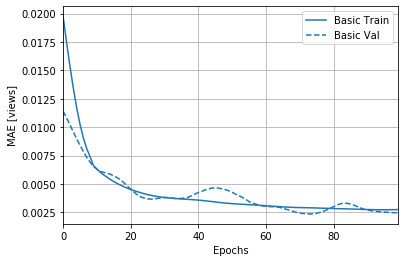

In [0]:
plotter.plot({'Basic': train_history}, metric = 'mean_absolute_error')
# plt.ylim([0, 1])
plt.ylabel('MAE [views]')

In [0]:
# test the neural network with the test data
loss, mae, mse = model.evaluate(test_dataset, test_labels)
test_predictions = model.predict(test_dataset).flatten()

1050/1050 [==============================] - 0s 59us/sample - loss: 4.1845e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 4.1845e-05


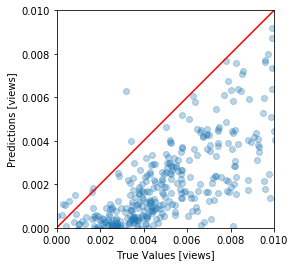

In [0]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions, alpha=0.3)
plt.xlabel('True Values [views]')
plt.ylabel('Predictions [views]')
lims = [0, 0.01]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='red')

In [0]:
train_dataset = train_dataset_ii.drop(columns=['cbow_titles_titles',
                                            'sg_titles_titles',
                                            'cbow_titles_tags','sg_titles_tags',
                                            'cbow_titles_descriptions',
                                            'sg_titles_descriptions',
                                            'cbow_titles_channels',
                                            'sg_titles_channels',
                                            'cbow_titles_categories',
                                            'sg_titles_categories',
                                            'cbow_tags_categories',
                                            'sg_tags_categories'])

test_dataset = test_dataset_ii.drop(columns=['cbow_titles_titles',
                                          'sg_titles_titles',
                                          'cbow_titles_tags','sg_titles_tags',
                                          'cbow_titles_descriptions',
                                          'sg_titles_descriptions',
                                          'cbow_titles_channels',
                                          'sg_titles_channels',
                                          'cbow_titles_categories',
                                          'sg_titles_categories',
                                          'cbow_tags_categories',
                                          'sg_tags_categories'])

In [0]:
# clean data
train_dataset = train_dataset.dropna()
test_dataset = test_dataset.dropna()

In [0]:
# normalize datasets
min_max_scaler = preprocessing.MinMaxScaler()

x = train_dataset.values.astype('float32')
normed_videos = min_max_scaler.fit_transform(x)
train_dataset = pd.DataFrame(normed_videos)

x = test_dataset.values.astype('float32')
normed_videos = min_max_scaler.fit_transform(x)
test_dataset = pd.DataFrame(normed_videos)

In [0]:
# get lengths of train and test datasets
print(train_dataset.shape[0])
print(test_dataset.shape[0])

4252
1050


In [0]:
train_dataset=train_dataset.values.astype('float32')
test_dataset=test_dataset.values.astype('float32')

TensorFlow Model

In [0]:
# build a neural network
model = build_model(150)

# fit the neural network with the training data
train_history = model.fit(train_dataset, train_labels, epochs=100, 
                          validation_split = 0.2,
                          callbacks=[tfdocs.modeling.EpochDots()])

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Train on 3401 samples, validate on 851 samples
Epoch 1/100
3008/3401 [=========================>....] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0298 - mean_squared_error: 0.0020
Epoch: 0, loss:0.0018,  mean_absolute_error:0.0277,  mean_squared_error:0.0018,  val_loss:0.0002,  val_mean_absolute_error:0.0090,  val_mean_squared_error:0.0002,  
3401/3401 [==============================] - 0s 142us/sample - loss: 0.0018 - mean_absolute_error: 0.0277 - mean_squared_error: 0.0018 - val_loss: 2.1033e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 2.1033e-04
Epoch 2/100
3401/3401 [==============================] - 0s 106us/sample - loss: 1.5601e-04 - mean_absolute_error: 0.0084 - mean_squared_error: 1.5601e-04 - val_loss: 5.9833e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 5.9833e-05
Epoch 3/100
3401/3401 [==============================] - 0s 99us/sample - loss: 8.6803e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 8.6803e-05 - val_loss: 9.555

Text(0, 0.5, 'MAE [views]')

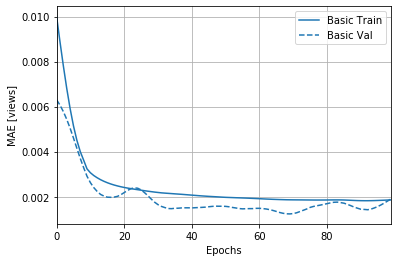

In [0]:
plotter.plot({'Basic': train_history}, metric = 'mean_absolute_error')
# plt.ylim([0, 1])
plt.ylabel('MAE [views]')

In [0]:
# test the neural network with the test data
loss, mae, mse = model.evaluate(test_dataset, test_labels)
test_predictions = model.predict(test_dataset).flatten()

1050/1050 [==============================] - 0s 65us/sample - loss: 5.8617e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 5.8617e-05


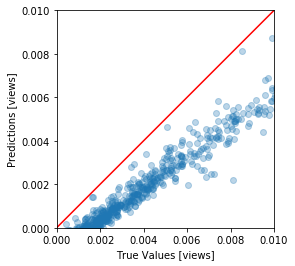

In [0]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions, alpha=0.3)
plt.xlabel('True Values [views]')
plt.ylabel('Predictions [views]')
lims = [0, 0.01]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='red')